In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
import tensorflow as tf
print("Is GPU available?", tf.config.list_physical_devices('GPU'))


E0000 00:00:1734720906.863994    3290 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734720906.929003    3290 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Is GPU available? []


In [3]:

# Paths
dataset_path = "../data/selected_categories/EuroSAT"
test_data_path = "../data/test_data"
output_dir = "../data/preprocessed_data"
categories = ["Forest", "Residential", "Highway", "AnnualCrop", "HerbaceousVegetation", "Industrial"]
image_size = 128  # Resize to 128x128


In [4]:
import os

# Debugging file existence
test_image = "random_neighborhood_1.JPG"
test_image_path = f"{test_data_path}/{test_image}"

if os.path.exists(test_image_path):
    print(f"Image found: {os.path.abspath(test_image_path)}")
else:
    print(f"Image not found. Current working directory: {os.getcwd()}")
    print(f"Looking for: {os.path.abspath(test_image_path)}")


Image found: /home/hyd_in_zrh/projects/data_science_projects/cas_deepL_project/data/test_data/random_neighborhood_1.JPG


In [5]:
## Purpose:

### To allow testing with any image (e.g., from your neighborhood), ensure it is preprocessed 
### (resized and normalized) just like the training images.


import cv2
import numpy as np

# Function to preprocess a single image
def preprocess_image(image_path, target_size=(128, 128)):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} not found.")
    
    # Resize the image
    img_resized = cv2.resize(img, target_size)
    
    # Normalize pixel values to [0, 1]
    img_normalized = img_resized / 255.0
    
    # Add batch dimension (if needed for model input)
    img_final = np.expand_dims(img_normalized, axis=0)  # Shape: (1, 128, 128, 3)
    
    return img_final



In [6]:
"""
Update Your Code to Handle Case-Sensitivity: Modify the file-checking logic to handle uppercase or mixed-case extensions (.JPG, .JPEG, .PNG, etc.):
"""

test_image = "random_neighborhood_1"
test_image_path = f"{test_data_path}/{test_image}"

import glob

# Locate the test image with case-insensitive matching
test_image_name = "random_neighborhood_1"
test_image_path = glob.glob(f"{test_data_path}/{test_image_name}.*", recursive=False)

if len(test_image_path) > 0:
    test_image_path = test_image_path[0]
    print(f"Image found: {test_image_path}")
else:
    raise ValueError(f"Image {test_image_name} not found in {test_data_path}")




Image found: ../data/test_data/random_neighborhood_1.JPG


In [7]:

preprocessed_image = preprocess_image(test_image_path)
print(f"Preprocessed image shape: {preprocessed_image.shape}")

Preprocessed image shape: (1, 128, 128, 3)


### preprocess in batches so as to not run into issues

In [8]:
import os
import cv2
import numpy as np


os.makedirs(output_dir, exist_ok=True)

# Preprocessing
for category in categories:
    category_path = os.path.join(dataset_path, category)
    output_path = os.path.join(output_dir, f"{category}.npy")
    
    print(f"Processing category: {category}")
    images = []
    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        try:
            img = cv2.imread(file_path)
            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Save preprocessed images to disk
    np.save(output_path, np.array(images))
    print(f"Saved preprocessed images for {category} to {output_path}")


Processing category: Forest
Saved preprocessed images for Forest to ../data/preprocessed_data/Forest.npy
Processing category: Residential
Saved preprocessed images for Residential to ../data/preprocessed_data/Residential.npy
Processing category: Highway
Saved preprocessed images for Highway to ../data/preprocessed_data/Highway.npy
Processing category: AnnualCrop
Saved preprocessed images for AnnualCrop to ../data/preprocessed_data/AnnualCrop.npy
Processing category: HerbaceousVegetation
Saved preprocessed images for HerbaceousVegetation to ../data/preprocessed_data/HerbaceousVegetation.npy
Processing category: Industrial
Saved preprocessed images for Industrial to ../data/preprocessed_data/Industrial.npy


Load Preprocessed Data

Combine all .npy files into a single dataset and create train/test splits.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
import os



# Batch loading function
def batch_split_and_save(output_dir, categories, test_size=0.2, val_size=0.2):
    for category in categories:
        file_path = os.path.join(output_dir, f"{category}.npy")
        print(f"Processing {category}")
        
        # Load the category data
        images = np.load(file_path)
        labels = np.full(len(images), categories.index(category))
        
        # Split into Train+Validation and Test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            images, labels, test_size=test_size, random_state=42
        )
        
        # Split Train+Validation into Training and Validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, random_state=42
        )
        
        # Save splits for this category
        np.save(os.path.join(output_dir, f"{category}_train.npy"), X_train)
        np.save(os.path.join(output_dir, f"{category}_val.npy"), X_val)
        np.save(os.path.join(output_dir, f"{category}_test.npy"), X_test)
        np.save(os.path.join(output_dir, f"{category}_train_labels.npy"), y_train)
        np.save(os.path.join(output_dir, f"{category}_val_labels.npy"), y_val)
        np.save(os.path.join(output_dir, f"{category}_test_labels.npy"), y_test)
        print(f"Saved splits for {category}")

batch_split_and_save(output_dir, categories)


Processing Forest
Saved splits for Forest
Processing Residential
Saved splits for Residential
Processing Highway
Saved splits for Highway
Processing AnnualCrop
Saved splits for AnnualCrop
Processing HerbaceousVegetation
Saved splits for HerbaceousVegetation
Processing Industrial
Saved splits for Industrial


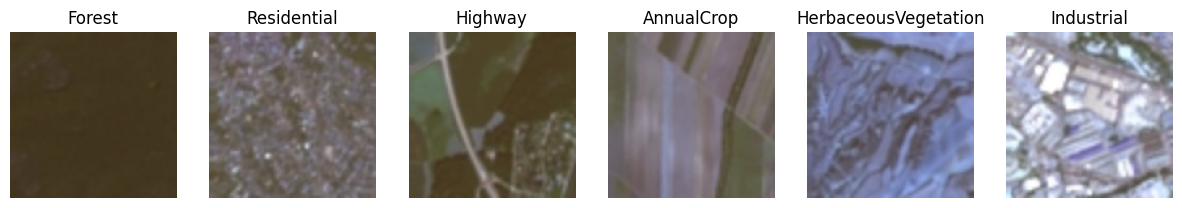

In [10]:
#display sample of one image per category

import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Function to visualize one random image from each category
def display_one_per_category(output_dir, categories):
    plt.figure(figsize=(15, 5))
    for i, category in enumerate(categories):
        # Load data for the category
        category_images = np.load(os.path.join(output_dir, f"{category}_train.npy"))
        
        # Randomly pick an image
        random_idx = random.randint(0, len(category_images) - 1)
        image = category_images[random_idx]
        
        # Display the image
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(image)
        plt.title(category)
        plt.axis("off")
    plt.show()

# Visualize one random image from each category
display_one_per_category(output_dir, categories)


### Below code works as follows:
        All categories are loaded into memory (X_train, y_train, etc.) at once, and then combined using np.concatenate.
        This approach works fine for smaller datasets but can cause issues (e.g., kernel dying) for large datasets due to memory spikes during concatenation.

    Memory Impact:
        Temporary copies of the arrays are created during concatenation, consuming more memory.

    Example:
        If each category has 1GB of data, concatenating all categories will briefly require ~6GB (categories + combined array).

Following code has:

    Each category is processed individually, and memory is reused for each category.
    Concatenation happens in smaller steps, avoiding memory spikes.

Why This Helps:

    By processing and combining one category at a time, memory usage stays low.
    The dataset grows incrementally instead of creating a large temporary copy.

In [11]:
def load_and_combine(output_dir, categories):
    X, y = [], []
    for category in categories:
        # Load data for one category
        X_data = np.load(os.path.join(output_dir, f"{category}_train.npy"))
        y_data = np.load(os.path.join(output_dir, f"{category}_train_labels.npy"))
        
        # Append directly to avoid full memory load
        X.append(X_data)
        y.append(y_data)
    
    # Combine after loading all categories
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

X_train, y_train = load_and_combine(output_dir, categories)
X_val, y_val = load_and_combine(output_dir, categories)
X_test, y_test = load_and_combine(output_dir, categories)


In [12]:
## to avoid following error duirng training, we do the following:
## ValueError: Arguments target and output must have the same rank (ndim). 
## Received: target.shape=(32,), output.shape=(32, 128, 128, 1)

import numpy as np

# Example: Expand y_train for binary segmentation
y_train = np.expand_dims(y_train, axis=(-1, -2, -3)) * np.ones((128, 128, 1), dtype=np.float32)
y_val = np.expand_dims(y_val, axis=(-1, -2, -3)) * np.ones((128, 128, 1), dtype=np.float32)
y_test = np.expand_dims(y_test, axis=(-1, -2, -3)) * np.ones((128, 128, 1), dtype=np.float32)

print("New y_train shape:", y_train.shape)


New y_train shape: (10880, 128, 128, 1)


In [13]:
print("X_train shape:", X_train.shape)  # Should be (batch_size, 128, 128, 3)
print("y_train shape:", y_train.shape)  # Should be (batch_size, 128, 128, 1)


X_train shape: (10880, 128, 128, 3)
y_train shape: (10880, 128, 128, 1)


In [14]:
### Balancing Classes
### Why This Matters:

### If your dataset has significantly more images for some categories (e.g., Forest) than others (e.g., Highway), the model may become biased toward the dominant classes. Balancing ensures fair contributions from all categories.
### Code to Check Class Balance

import numpy as np
import os


# Check training set balance
class_counts = {}
for category in categories:
    labels = np.load(os.path.join(output_dir, f"{category}_train_labels.npy"))
    class_counts[category] = len(labels)

# Print class distribution
for category, count in class_counts.items():
    print(f"{category}: {count} images")


Forest: 1920 images
Residential: 1920 images
Highway: 1600 images
AnnualCrop: 1920 images
HerbaceousVegetation: 1920 images
Industrial: 1600 images


In [15]:
import os
import tensorflow as tf

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Initialize TensorFlow
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available:", physical_devices)




TensorFlow version: 2.18.0
GPUs Available: []


## Step 1: Define the U-Net Architecture

In [16]:
from tensorflow.keras import layers, Model

def unet(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.1)(p1)  # Add dropout after pooling

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)  # Add dropout after pooling

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.2)(p3)  # Increase dropout for deeper layers

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.2)(p4)  # Add dropout after pooling

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.3)(c5)  # Add dropout in the bottleneck

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [1]:

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy(None)

# Confirm the policy
print("Mixed precision policy set to:", tf.keras.mixed_precision.global_policy().name)


E0000 00:00:1734721230.217397    3373 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734721230.273334    3373 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ValueError: Invalid `policy` argument. Expected the string name of a policy (such as 'mixed_float16') or a `DTypePolicy` instance. Received: policy=None (of type <class 'NoneType'>)

In [3]:
import numpy as np
X_train_subset = np.random.rand(1000, 32, 32, 3)
y_train_subset = np.random.randint(0, 2, size=(1000, 32, 32, 1))


In [18]:
def iou_metric(y_true, y_pred):
    # Convert predictions to binary (0 or 1) for IoU calculation
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    
    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred - y_true * y_pred)
    
    # Avoid division by zero
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou



##  Step 2: Compile the Model

In [19]:
model = unet(input_size=(64, 64, 3))  # Smaller input size for debugging


In [20]:
# Compile model with IoU metric
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Adam is compatible with mixed_float16

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', iou_metric])


## Step 3: Train the Model

using tf.data.Dataset for the following reasons:

    Scalability and Efficiency:
        It is optimized for TensorFlow's ecosystem, ensuring seamless and efficient data loading, preprocessing, and feeding into the model, especially when working with larger datasets or advanced architectures.

    Simpler Code:
        Handling shuffling, batching, and preprocessing manually can get cumbersome and error-prone. tf.data.Dataset simplifies the workflow with its high-level API.

    Future-Proofing:
        If your project grows to include larger datasets, distributed training, or dynamic preprocessing (e.g., image augmentation), tf.data.Dataset will already be set up to handle these seamlessly.

    GPU Utilization:
        It supports prefetching, which allows data preparation and model computation to overlap, making better use of your GPU resources.
    
    Why prefetch?

    The .prefetch(tf.data.AUTOTUNE) method ensures that the next batch is prepared while the current batch is being processed by the GPU, reducing idle time and speeding up training.

In [21]:
import os
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Set up mixed precision
set_global_policy('mixed_float16')

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Confirm the policy
print("Mixed precision policy set to:", tf.keras.mixed_precision.global_policy().name)


Mixed precision policy set to: mixed_float16


In [22]:
# Reduce batch size
batch_size = 2

# Use only the first 1000 samples for debugging
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]
X_val_subset = X_val[:500]
y_val_subset = y_val[:500]
X_test_subset = X_test[:500]
y_test_subset = y_test[:500]


try:
    # Define datasets for the subset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_subset, y_val_subset))
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
except Exception as e:
    print("Error encountered:", e)


# Print shapes to confirm subset sizes
print(X_train_subset.shape, y_train_subset.shape)
print(X_val_subset.shape, y_val_subset.shape)
print(X_test_subset.shape, y_test_subset.shape)


(1000, 128, 128, 3) (1000, 128, 128, 1)
(500, 128, 128, 3) (500, 128, 128, 1)
(500, 128, 128, 3) (500, 128, 128, 1)


### train the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5


## Step 4: Evaluate the Model

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss, Test Accuracy:", results)


## Step 5: Save the Model

In [ ]:
model.save("unet_greenery_detection.h5")


Visualize Results: After training, visualize the model's predictions on test images to assess performance:

In [ ]:
import matplotlib.pyplot as plt

sample_image = X_test[0]
sample_mask = y_test[0]
prediction = model.predict(sample_image[None, ...])[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(sample_image)
plt.subplot(1, 3, 2); plt.title("Ground Truth"); plt.imshow(sample_mask, cmap="gray")
plt.subplot(1, 3, 3); plt.title("Prediction"); plt.imshow(prediction, cmap="gray")
plt.show()
